In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.fft import dct, idct
# from scipy.interpolate import interp1d, BarycentricInterpolator, CubicSpline

# importing ot lib just to compare with other solution
import ot

from tqdm import tqdm
import time

# The Back-and-Forth Algorithm

Let our $\Omega \subset \R^d$ be a convex and compact region. Consider a cost function of a form
$$ c(x, y) = h(y-x) $$
where function $h : \R^d \to \R$ is strictly convex and even function.

The optimal transport problem is being stated in it's dual form:
$$ C(\mu, \nu) = \sup_{\varphi : \Omega \to \R} \int_{\Omega} \varphi(y) \nu(y) dy + \int_{\Omega} (\varphi)^{c} (x) \mu(x) dx $$
for two measures $\mu$ and $\nu$ and continuous functions $\varphi: \Omega \to \R$.

The operation $(\cdot)^{c}$ is called __c-transform__ and is being defined as:
$$ \varphi^{c}(x) = \inf_{y \in \Omega} \left\{ c(x,y) - \varphi(y) \right\} $$

Also we define two functionals $J: \mathcal{H} \to \R$ and $I: \mathcal{H} \to \R$
$$ J(\varphi) = \int_{\Omega} \varphi d \nu + \int_{\Omega} \varphi^{c} d \mu $$
$$ I(\psi) = \int_{\Omega} \psi^{c} d \nu + \int_{\Omega} \psi d \mu $$

And our operating Hilbert space will be
$$ \dot{H}^1 = \left\{ \varphi : \Omega \to \R : \int_{\Omega} \varphi dx = 0 \text{ and } \nabla \varphi \in L^2 (\Omega) \right\} $$

We get the following update scheme
$$
\begin{align*}
\varphi_{n+1/2} &= \varphi_{n} + \sigma \nabla_{\dot{H}^1} J(\varphi_{n}) \\
\psi_{n+1/2}    &= (\varphi_{n+1/2})^{c} \\
\psi_{n+1}    &= \psi_{n} + \sigma \nabla_{\dot{H}^1} I(\psi_{n}) \\
\varphi_{n+1}   &= (\psi_{n+1})^{c}
\end{align*}
$$

where the functionals $J(\varphi_n)$ and $I(\psi_n)$ are defined as:
$$ J(\varphi) = \int_{\Omega} \varphi d \nu + \int_{\Omega} (\varphi)^{c} d \mu $$
$$ I(\psi) = \int_{\Omega} (\psi)^{c} d \nu + \int_{\Omega} \psi d \mu $$
over the space of continuous functions $\varphi : \Omega \to \R$ and $\psi : \Omega \to \R$.

How do we compute $\nabla_{\dot{H}^1} J(\varphi_n)$ or $\nabla_{\dot{H}^1} I(\psi_n)$?

$$ \nabla_{\dot{H}^1} J(\varphi) = (-\Delta)^{-1} (\nu - T_{\varphi \#} \mu) $$
$$ \nabla_{\dot{H}^1} I(\psi) = (-\Delta)^{-1} (\mu - T_{\psi \#} \nu) $$

Here $(\Delta)^{-1}$ is the inverse Laplace operator which we get while solving this PDE:
$$
\begin{cases}
    - \Delta \varphi &= f \\
    \nabla \varphi &= 0 \quad \text{ on } \partial \Omega \quad \text{ (Neumann Boundary Condition) }
\end{cases}
$$

So here the function $f$ is equal to either $\nu - T_{\varphi \#} \mu$ or $\mu - T_{\psi \#} \nu$.



<!-- $$
    \rho_n = T_{\varphi_n \#} \mu  \qquad  \rho_{n+1/2} = T_{\varphi_{n+1/2} \#} \mu
$$ -->

### C-Transform and Pushforward

Let's remind ourselfes what c-transform of a function $\varphi$ is:

$$ \varphi^{c}(x) = \inf_{y \in \Omega} \left\{ c(x,y) - \varphi(y) \right\} $$

But for the dual problem and cost $c(x, y) = h(y-x) = \frac{1}{2} |y - x|^{2}$ we got

$$ \varphi^{c}(x) = \sup_{y} \left\{ x \cdot y - \varphi(y) \right\} $$

In [2]:
def ctransform1d(phi: np.ndarray, cost: np.ndarray) -> np.ndarray:
    transform = (cost - phi).max(axis=1)
    return transform

The map $T$ is defined as $x$ minus the inverse gradient 
of $h$ applied to gradient of the potential for potential $\varphi$:
$$ T_{\varphi}(x) = x - (\nabla h)^{-1} ( \nabla \varphi^{c}(x) ) $$
$$ T_{\psi}(y) = y - (\nabla h)^{-1} ( \nabla \psi^{c}(y) ) $$

Then the pushforward of a measure $\mu$ for a set $A$:
$$ T_{\#}\mu (A) = \mu ( T^{-1} (A) ) $$

For quadratic cost the pushforward operation is simplified to:
$$ T_{\varphi} (x) = x - \nabla \varphi^{c} (x) $$
$$ T_{\psi} (y) = y - \nabla \psi^{c} (y) $$

Since
$$ h(y-x) = \frac{1}{2} (y-x)^2 \; \implies \; \nabla h(y-x) = y-x
\; \implies \; (\nabla h)(\nabla \varphi^{c} (x)) = \nabla \varphi^{c} (x)  $$

And for the dual problem we get
$$ T_{\varphi}(x) = \nabla \varphi^{c} (x)

In [3]:
def map_T1d(phi: np.ndarray, cost: np.ndarray, x: np.ndarray) -> np.ndarray:
    return np.gradient(
        ctransform1d(phi, cost),
        x,
    )

In [4]:
def pushforward1d(mu: np.ndarray, T: np.ndarray, x: np.ndarray) -> np.ndarray:
    pushforward_mu = np.zeros_like(mu)

    # distribute the mass according to the transformed positions
    for i, m in enumerate(mu):
        closest_idx = np.argmin(np.abs(x - T[i]))
        pushforward_mu[closest_idx] += m

    # Normalize to maintain total mass
    pushforward_mu /= np.sum(pushforward_mu) / np.sum(mu)

    return pushforward_mu

### Gradient and PDE

Let's remind ourselfes the formula to get the gradient:
$$ \nabla_{\dot{H}^1} J(\varphi) = (-\Delta)^{-1} (\nu - T_{\varphi \#} \mu) $$
$$ \nabla_{\dot{H}^1} I(\psi) = (-\Delta)^{-1} (\mu - T_{\psi \#} \nu) $$

Here $(\Delta)^{-1}$ is the inverse Laplace operator which we get while solving this PDE:
$$
\begin{cases}
    - \Delta \varphi &= f \\
    \nabla \varphi &= 0 \quad \text{ on } \partial \Omega \quad \text{ (Neumann Boundary Condition) }
\end{cases}
$$

So here the function $f$ is equal to either $\nu - T_{\varphi \#} \mu$ or $\mu - T_{\psi \#} \nu$.

In [5]:
def solve_pde1d(f, L, N):
    """
    Solves the Poisson equation -∆phi = f with Neumann boundary conditions
    using the Discrete Cosine Transform.

    Parameters:
    f : ndarray
        The source term of the Poisson equation.
    L : float
        The length of the domain.
    N : int
        The number of discretization points.

    Returns:
    x : ndarray
        The discretized domain.
    phi : ndarray
        The solution of the Poisson equation.
    """
    f_hat = dct(f, norm='ortho')
    k = np.pi * np.arange(N) / L
    k[0] = 1  # avoid division by zero
    # Compute the solution in the spectral domain
    phi_hat = f_hat / (k**2)
    phi_hat[0] = 0
    # compute the inverse discrete cosine transform to get the spatial solution
    phi = idct(phi_hat, norm='ortho')
    return phi

In [6]:
def gradient1d(nu: np.ndarray, t_mu: np.ndarray, x: np.ndarray):
    f = t_mu - nu
    L = x[-1]
    phi = solve_pde1d(f, L, x.size)
    return phi

Parameter $\sigma$ value is updated thoughout the algorithm.
In the article Armijo-Goldstein update rules are used.

For the objective function $f$, current point $x$ and search direction $p$ (gradient) we check the following condition
$$ f(x + \sigma p) \le f(x) + c \sigma \nabla f(x) ^{T} p $$
where $c$ is some small constant.
We do the updates in the following way:
- if $f(x + \sigma p) - f(x) \gt (c \sigma \nabla f(x) ^{T} p) \cdot u$ then we increase $\sigma$
- if $f(x + \sigma p) - f(x) \lt (c \sigma \nabla f(x) ^{T} p) \cdot l$ then we decrease $\sigma$

where $u$ and $l$ are upper and lower bounds (in a range from 0 to 1).

In our algorithm we compare the difference $J(\varphi_{n+1}) - J(\varphi_n)$ to the square norm
$\| \nabla J(\varphi_n) \|^2$. Correspondingly for $I(\psi_{n+1})$.

In [7]:
def compute_dual(phi: np.ndarray, psi: np.ndarray, mu: np.ndarray,
                 nu: np.ndarray, x: np.ndarray, y: np.ndarray):
    n = phi.size
    return np.sum(0.5 * (x*x+y*y) * (mu + nu) - nu*phi - mu*psi)/(n)


def stepsize_update(sigma, value, oldValue, gradSq):
    diff = value - oldValue
    scaleDown = 0.95
    scaleUp = 1/scaleDown
    upper = 0.75
    lower = 0.25

    if diff > gradSq * sigma * upper:
        return sigma * scaleUp
    elif diff < gradSq * sigma * lower:
        return sigma * scaleDown
    return sigma


def back_and_forth1d(
        x: np.ndarray,
        y: np.ndarray,
        mu: np.ndarray,
        nu: np.ndarray,
        cost: np.ndarray,
        sigma: float = 0.01,
        iterations: int = 20,
        accuracy: float = 1e-10,
):
    phi = -np.ones_like(x)
    psi = -np.ones_like(y)
    n, m = x.size, y.size

    rho = np.copy(mu)
    oldValue = compute_dual(phi, psi, mu, nu, x, y)
    h1err_history = np.empty((1, 1))
    mu_history = np.copy(mu)[np.newaxis, :]
    nu_history = np.empty((1, m))

    with tqdm(range(iterations)) as pbar:
        for i in pbar:
            rho = pushforward1d(
                mu,
                map_T1d(phi, cost, y),
                x
            )
            phi_grad = gradient1d(
                nu,
                rho,
                x,
            )
            phi += sigma * phi_grad

            h1_error = np.sum(phi_grad * (rho - nu)) / n

            psi = ctransform1d(phi, cost)
            phi = ctransform1d(psi, cost)

            value = compute_dual(phi, psi, mu, nu, x, y)
            sigma = stepsize_update(sigma, value, oldValue, h1_error)
            oldValue = value

            # for animations store nu
            nu_history = np.vstack([nu_history, rho])

            rho = pushforward1d(
                nu,
                map_T1d(psi, cost, x),
                y
            )
            psi_grad = gradient1d(
                mu,
                rho,
                y,
            )
            psi += sigma * psi_grad

            h1_error = np.sum(psi_grad * (rho - mu)) / n

            phi = ctransform1d(psi, cost.T)
            psi = ctransform1d(phi, cost)

            value = compute_dual(phi, psi, mu, nu, x, y)
            sigma = stepsize_update(sigma, value, oldValue, h1_error)
            oldValue = value

            # for animations store mu
            mu_history = np.vstack([mu_history, rho])

            h1err_history = np.append(h1err_history, h1_error)

            pbar.set_postfix(h1=h1_error)
            if accuracy > h1_error:
                print(f"Attained needed error of {h1_error}")
                return phi, psi, h1err_history, mu_history, nu_history

    return phi, psi, h1err_history, mu_history, nu_history


# Quantization

We may consider several options for the discretization of the space. One approach is the quantization of the values of our measures, followed by finding a grid that respects this quantization.

The `find_quantization_points` function performs quantization by dividing the cumulative distribution function (CDF) into equal-area segments. This approach ensures that each quantized interval represents an equal probability mass.

The `refine_grid` function takes the quantization points and adds intermediate points in larger intervals. This refinement helps to capture more detail in areas where the PDF may have significant variation.


In [8]:
def find_quantization_points(pdf, bounds, num_points, approx_num_points=10_000):
    x = np.linspace(bounds[0], bounds[1], approx_num_points)
    y = pdf(x)
    # Calculate the area under the PDF (using the trapezoidal rule)
    dx = x[1] - x[0]
    cumulative_area = np.cumsum(y) * dx
    total_area = cumulative_area[-1]

    # Determine target areas for each quantile
    target_areas = np.linspace(0, total_area, num_points + 1)[1:-1]

    # Find indices where the cumulative area surpasses each target area
    quantization_indices = np.searchsorted(cumulative_area, target_areas)
    quantization_points = x[quantization_indices]

    return quantization_points


def refine_grid(points):
    num_intervals = points.shape[0] - 1
    refined_points = np.copy(points)
    mean_diff = np.mean(np.gradient(points))
    
    for i in range(num_intervals):
        start = points[i]
        end = points[i + 1]
        
        if end - start < mean_diff * 4:
            continue

        scale = max(int((end - start) / (mean_diff * 4)), 2)
        addition = np.linspace(start, end, scale)[1:-1]
        refined_points = np.append(refined_points, addition)

    # Combine the original points with the new refined points and sort them
    return np.sort(np.unique(np.concatenate([points, refined_points])))

# 1-D Examples

## Gaussians

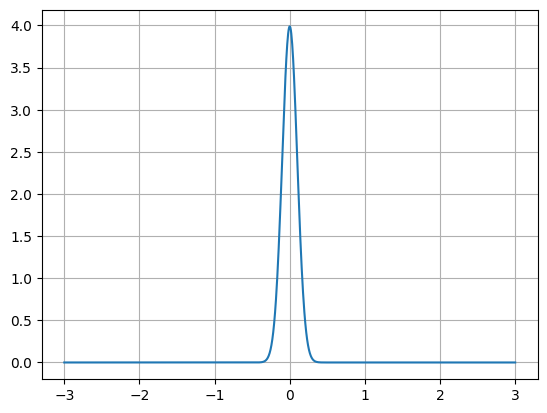

In [9]:
def gaussian(mu, std):
    def pdf(x):
        return 1/(np.sqrt(2 * np.pi * std**2)) * np.exp(
            -1/2 * np.power((x - mu), 2) / np.power(std, 2) )
    return pdf

pdf = gaussian(0, 0.1)
x = np.linspace(-3, 3, 1000)

plt.plot(x, pdf(x))
plt.grid()

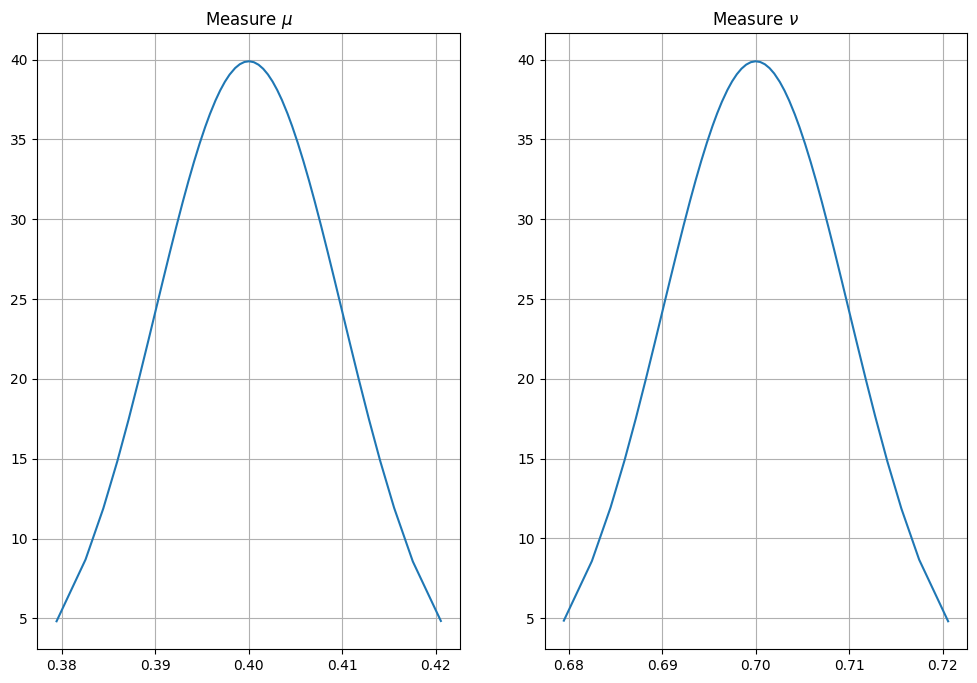

In [10]:
n = 50
range_min = 0
range_max = 1

pdf1 = gaussian(0.4, .01)
pdf2 = gaussian(0.7, .01)

x = find_quantization_points(
    pdf1,
    [range_min, range_max],
    n,
)
y = find_quantization_points(
    pdf2,
    [range_min, range_max],
    n,
)

X, Y = np.meshgrid(x, y, indexing='ij')

mu = pdf1(x)
nu = pdf2(y)

fig, axs = plt.subplots(1, 2, figsize=(12,8))
axs[0].plot(x, mu)
axs[0].set_title('Measure $\\mu$')
axs[0].grid()
axs[1].plot(y, nu)
axs[1].set_title('Measure $\\nu$')
axs[1].grid()

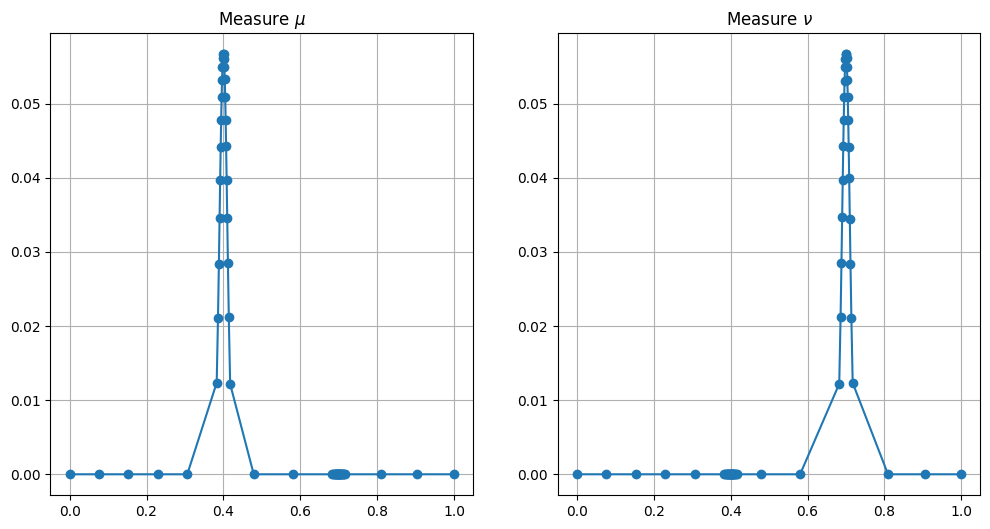

In [11]:
x_points = find_quantization_points(lambda x: (pdf1(x) + pdf2(x))/2, [range_min, range_max], n)
x_points = np.insert(x_points, 0, [0])
x_points = np.insert(x_points, -1, [1])
x_refined = refine_grid(x_points)
mu = pdf1(x_refined)
nu = pdf2(x_refined)

mu /= mu.sum()
nu /= nu.sum()

X, Y = np.meshgrid(x_refined, x_refined, indexing='ij')

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(x_refined, mu, marker='o')
axs[0].set_title('Measure $\\mu$')
axs[0].grid(True)

axs[1].plot(x_refined, nu, marker='o')
axs[1].set_title('Measure $\\nu$')
axs[1].grid(True)

plt.show()

Text(0.5, 1.0, 'Cost matrix $\\frac{1}{2}(x-y)^{2}$ of Primal Problem')

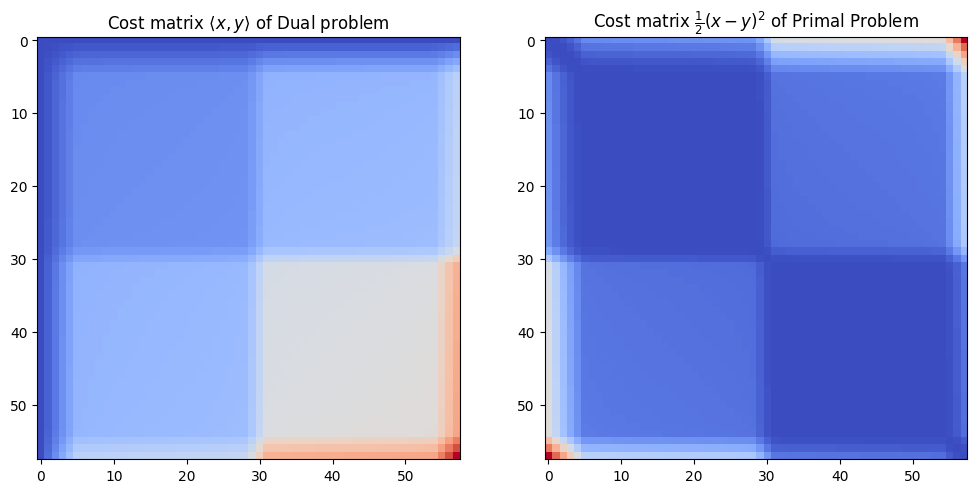

In [12]:
c = X * Y
cost = np.power(X - Y, 2) / 2

fig, axs = plt.subplots(1, 2, figsize=(12,8))
axs[0].imshow(c, cmap='coolwarm')
axs[0].set_title('Cost matrix $\\left<x, y\\right>$ of Dual problem')
axs[1].imshow(cost, cmap='coolwarm')
axs[1].set_title('Cost matrix $\\frac{1}{2}(x-y)^{2}$ of Primal Problem')

In [13]:
%%time
sigma_init = 0.1
phi, psi, err1, mus, nus = back_and_forth1d(
    x_refined, x_refined, mu, nu, c, sigma=sigma_init, iterations=1000, accuracy=1e-12)

100%|██████████| 1000/1000 [00:03<00:00, 272.69it/s, h1=6.23e-12]

CPU times: user 3.08 s, sys: 796 ms, total: 3.87 s
Wall time: 3.69 s


Text(0.5, 1.0, '$\\psi$')

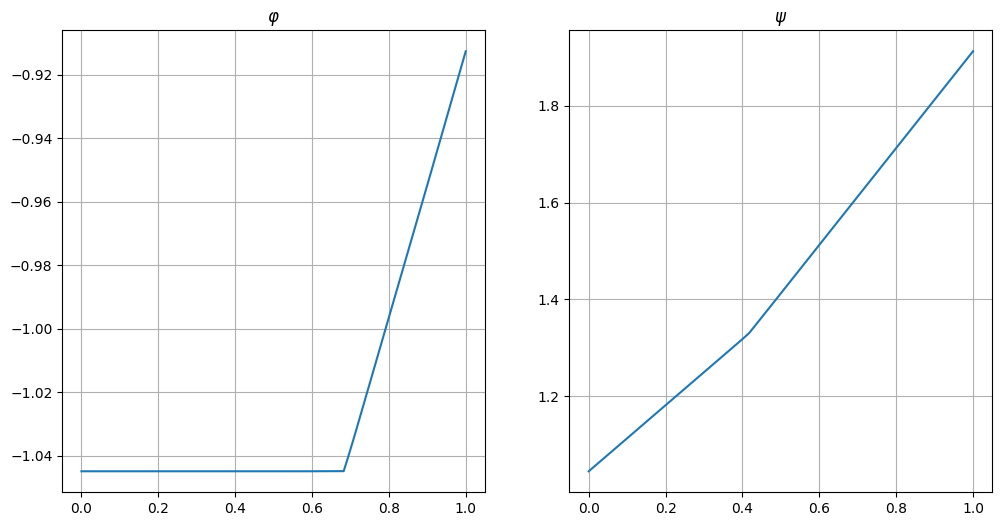

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))
axs[0].plot(x_refined, phi)
axs[0].grid()
axs[0].set_title('$\\varphi$')
axs[1].plot(x_refined, psi)
axs[1].grid()
axs[1].set_title('$\\psi$')

In [15]:
rho1 = pushforward1d(mu, map_T1d(phi, c, x_refined), x_refined)

rho2 = pushforward1d(nu, map_T1d(psi, c, x_refined), x_refined)

T_psi = map_T1d(psi, c, x_refined)
T_phi = map_T1d(phi, c, x_refined)
T = np.zeros((x_refined.shape[0], x_refined.shape[0]))
for i, val in enumerate(T_psi):
    j = np.argmin(np.abs(x_refined - val))
    if rho1[i] != 0 and rho2[j] != 0:
        T[i, j] = rho1[i]

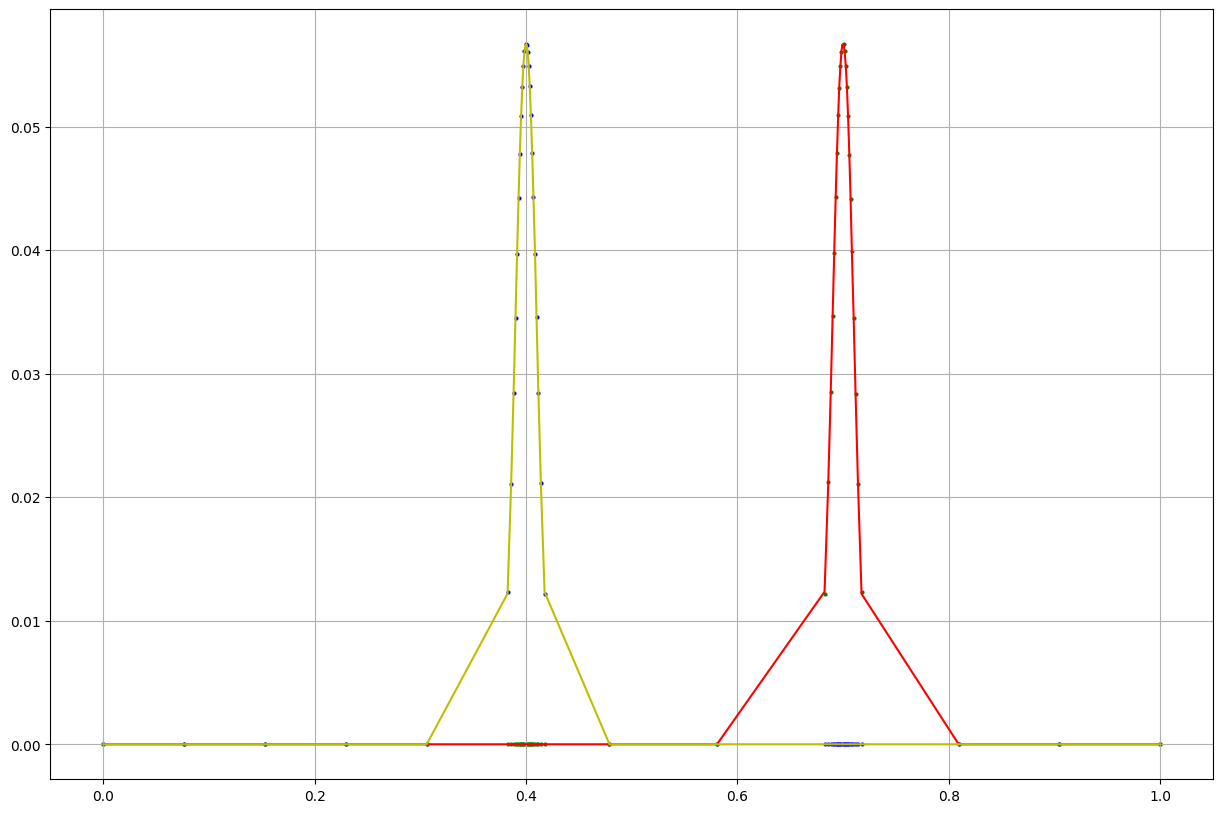

In [16]:
fig, axs = plt.subplots(1, 1, figsize=(15,10))
axs.plot(x_refined, rho1, 'r')
axs.plot(x_refined, rho2, 'y')
axs.scatter(x_refined, mu, c='b', s=4)
axs.scatter(x_refined, nu, c='g', s=4)
axs.grid()

EMD is done in 0.0015010833740234375 sec.


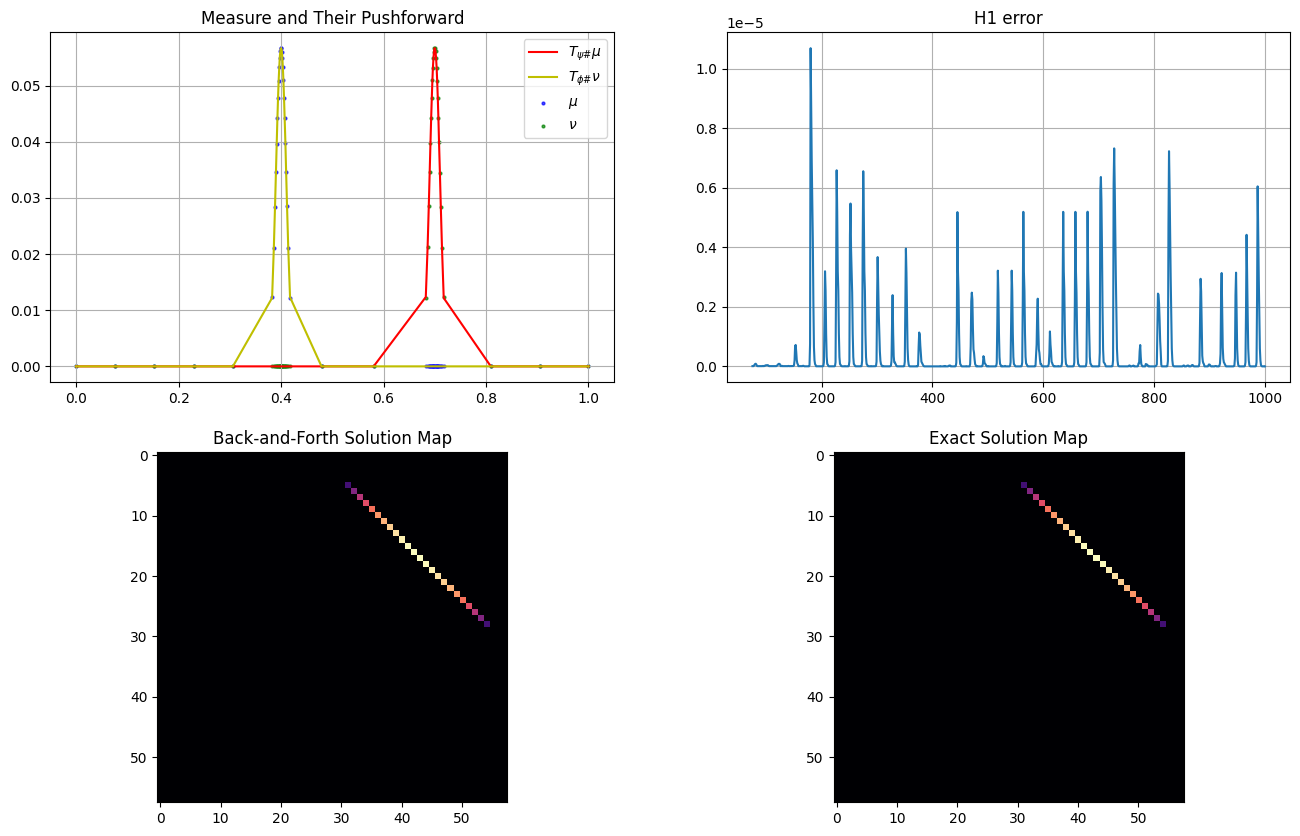

In [17]:
exact_start = time.time()
exact_sol = ot.emd(mu, nu, cost)
print(f"EMD is done in {time.time() - exact_start} sec.")

fig, axs = plt.subplots(2, 2, figsize=(16, 10))

axs[0][0].plot(x_refined, rho1, 'r', label='$T_{\\psi \\#}\\mu$')
axs[0][0].plot(x_refined, rho2, 'y', label='$T_{\\phi \\#}\\nu$')
axs[0][0].scatter(x_refined, mu, s=4, alpha=0.7, c='b', label='$\\mu$')
axs[0][0].scatter(x_refined, nu, s=4, alpha=0.7, c='g', label='$\\nu$')
axs[0][0].legend()
axs[0][0].grid()
axs[0][0].set_title('Measure and Their Pushforward')

err_start = 75
axs[0][1].plot(np.arange(err_start, err1.size), err1[err_start:])
axs[0][1].set_title('H1 error')
axs[0][1].grid()
axs[1][0].imshow(T.T, cmap='magma')
axs[1][0].set_title('Back-and-Forth Solution Map')
axs[1][1].imshow(exact_sol, cmap='magma')
axs[1][1].set_title('Exact Solution Map')
plt.show()

We can create an animation how our pushforwards are converging to the measures

In [18]:
%
### comment line above to run the cell
from matplotlib.animation import FuncAnimation

nframes = mus.shape[0]

fig, ax = plt.subplots(figsize=(12, 8))
ax.grid()
ax.set_ylim(0, 0.1)
ax.scatter(x_refined, mu, c='b', s=4)
ax.scatter(x_refined, nu, c='y', s=4)
mu_line, = ax.plot(x_refined, mus[0, :], 'r-')
nu_line, = ax.plot(x_refined, nus[0, :], 'g-')


def update(frame):
    mu_line.set_ydata(mus[frame, :])
    nu_line.set_ydata(nus[frame, :])
    return mu_line, nu_line


ani = FuncAnimation(fig, update, frames=range(nframes), blit=True, interval=100)

ani.save('measure_changes.mp4', writer='ffmpeg')  # requires ffmpeg to be installed

UsageError: Line magic function `%` not found.


## Dirac measures

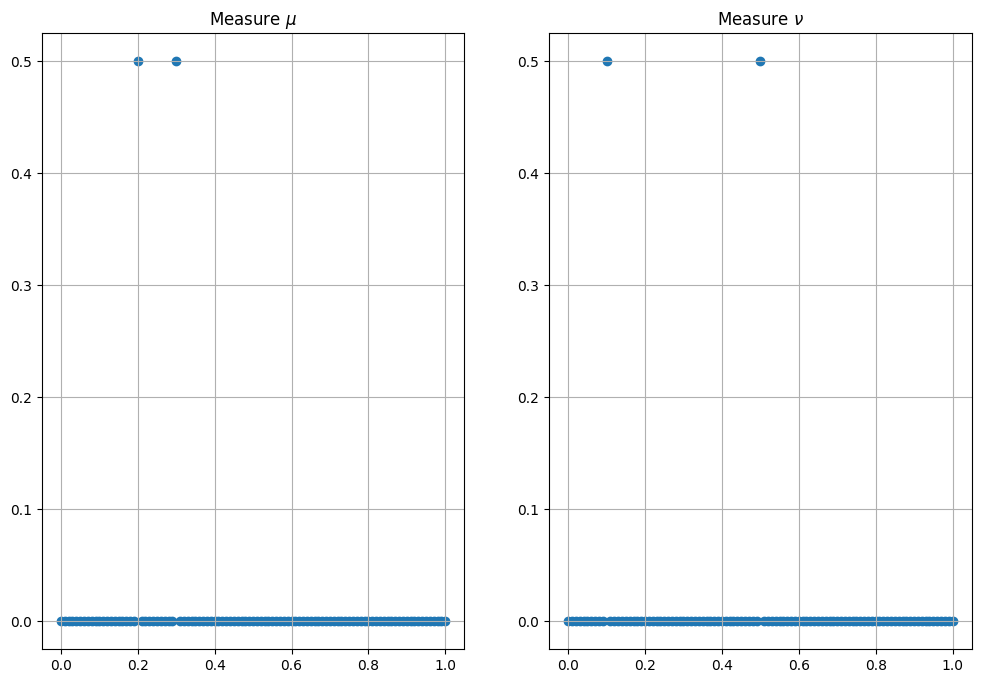

In [19]:
n = 100 + 1
range_min = 0
range_max = 1

x = np.linspace(range_min, range_max, n)
X, Y = np.meshgrid(x, x, indexing='ij')

mu = np.zeros(n)
mu[np.searchsorted(x, 0.2)] = 1
mu[np.searchsorted(x, 0.3)] = 1
mu /= mu.sum()
nu = np.zeros(n)
nu[np.searchsorted(x, 0.1)] = 1
nu[np.searchsorted(x, 0.5)] = 1
nu /= nu.sum()

fig, axs = plt.subplots(1, 2, figsize=(12,8))
axs[0].scatter(x, mu)
axs[0].set_title('Measure $\\mu$')
axs[0].grid()
axs[1].scatter(x, nu)
axs[1].set_title('Measure $\\nu$')
axs[1].grid()

In [20]:
c = X * Y
cost = np.power(X - Y, 2) / 2

In [21]:
%%time
sigma_init = 0.1
phi, psi, err1, mus, nus = back_and_forth1d(
    x, x, mu, nu, c, sigma=sigma_init, iterations=2000, accuracy=1e-14)

  2%|▏         | 38/2000 [00:00<00:08, 226.92it/s, h1=0]      

Attained needed error of 0.0
CPU times: user 154 ms, sys: 41.4 ms, total: 195 ms
Wall time: 174 ms


EMD is done in 0.0007562637329101562 sec.


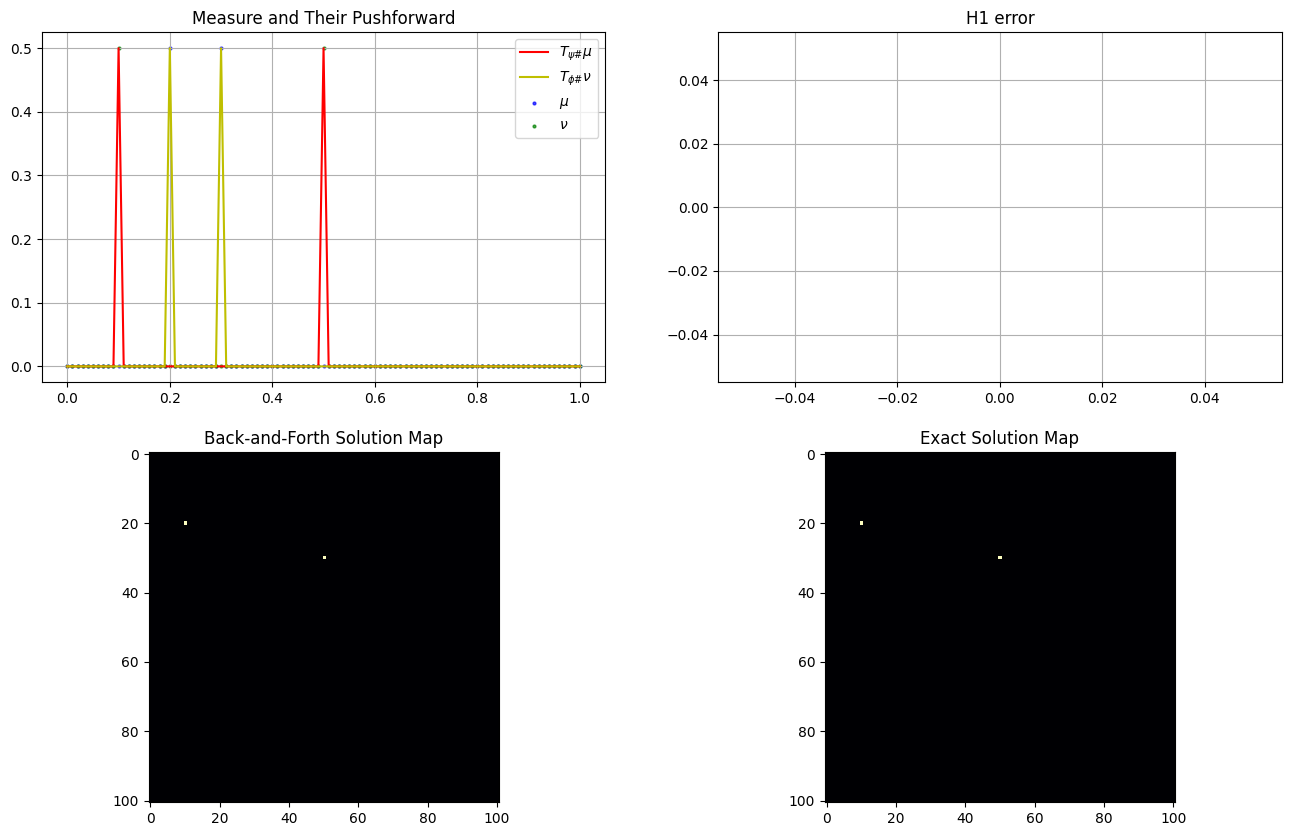

In [22]:
rho1 = pushforward1d(mu, map_T1d(phi, c, x), x)

rho2 = pushforward1d(nu, map_T1d(psi, c, x), x)

T_psi = map_T1d(psi, c, x)
T_phi = map_T1d(phi, c, x)
T = np.zeros((n, n))
for i, val in enumerate(T_psi):
    j = np.argmin(np.abs(x - val))
    if rho1[i] != 0 and rho2[j] != 0:
        T[i, j] = rho1[i]

exact_start = time.time()
exact_sol = ot.emd(mu, nu, cost)
print(f"EMD is done in {time.time() - exact_start} sec.")

fig, axs = plt.subplots(2, 2, figsize=(16, 10))

axs[0][0].plot(x, rho1, 'r', label='$T_{\\psi \\#}\\mu$')
axs[0][0].plot(x, rho2, 'y', label='$T_{\\phi \\#}\\nu$')
axs[0][0].scatter(x, mu, s=4, alpha=0.7, c='b', label='$\\mu$')
axs[0][0].scatter(x, nu, s=4, alpha=0.7, c='g', label='$\\nu$')
axs[0][0].legend()
axs[0][0].grid()
axs[0][0].set_title('Measure and Their Pushforward')

err_start = 75
axs[0][1].plot(np.arange(err_start, err1.size), err1[err_start:])
axs[0][1].set_title('H1 error')
axs[0][1].grid()
axs[1][0].imshow(T.T, cmap='magma')
axs[1][0].set_title('Back-and-Forth Solution Map')
axs[1][1].imshow(exact_sol, cmap='magma')
axs[1][1].set_title('Exact Solution Map')
plt.show()

## Gaussians with different variance

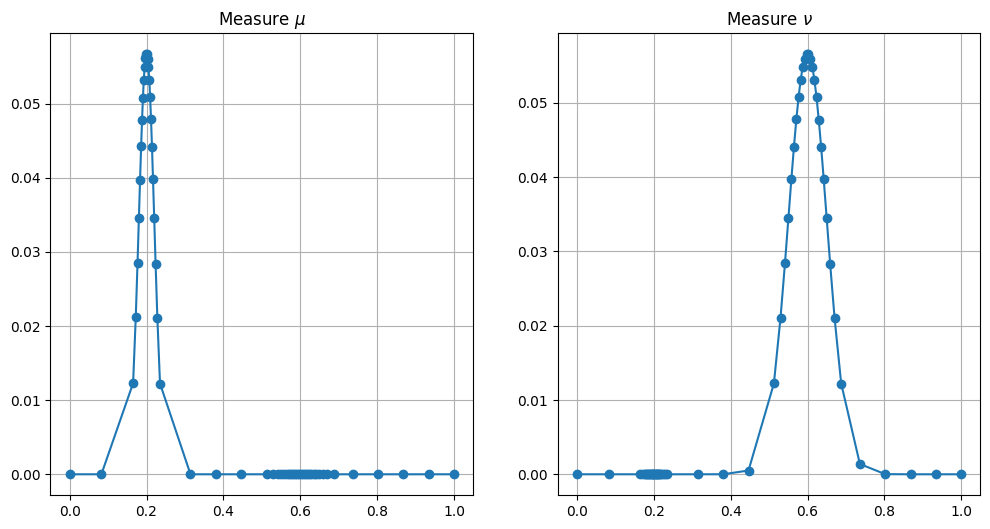

In [23]:
n = 50
range_min = 0
range_max = 1

pdf1 = gaussian(0.2, .02)
pdf2 = gaussian(0.60, .05)

x = find_quantization_points(
    pdf1,
    [range_min, range_max],
    n,
)
y = find_quantization_points(
    pdf2,
    [range_min, range_max],
    n,
)

X, Y = np.meshgrid(x, y, indexing='ij')

mu = pdf1(x)
nu = pdf2(y)

x_points = find_quantization_points(lambda x: (pdf1(x) + pdf2(x))/2, [range_min, range_max], n)
x_points = np.insert(x_points, 0, [0])
x_points = np.insert(x_points, -1, [1])
x_refined = refine_grid(x_points)

mu = pdf1(x_refined)
nu = pdf2(x_refined)

mu /= mu.sum()
nu /= nu.sum()

X, Y = np.meshgrid(x_refined, x_refined, indexing='ij')

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(x_refined, mu, marker='o')
axs[0].set_title('Measure $\\mu$')
axs[0].grid(True)
axs[1].plot(x_refined, nu, marker='o')
axs[1].set_title('Measure $\\nu$')
axs[1].grid(True)

plt.show()

In [24]:
c = X * Y
cost = np.power(X - Y, 2) / 2

phi, psi, err1, mus, nus = back_and_forth1d(
    x_refined, x_refined, mu, nu, c, sigma=0.1,
    iterations=1500, accuracy=1e-11)

100%|██████████| 1500/1500 [00:06<00:00, 249.83it/s, h1=2.88e-9] 


EMD is done in 0.0018639564514160156 sec.


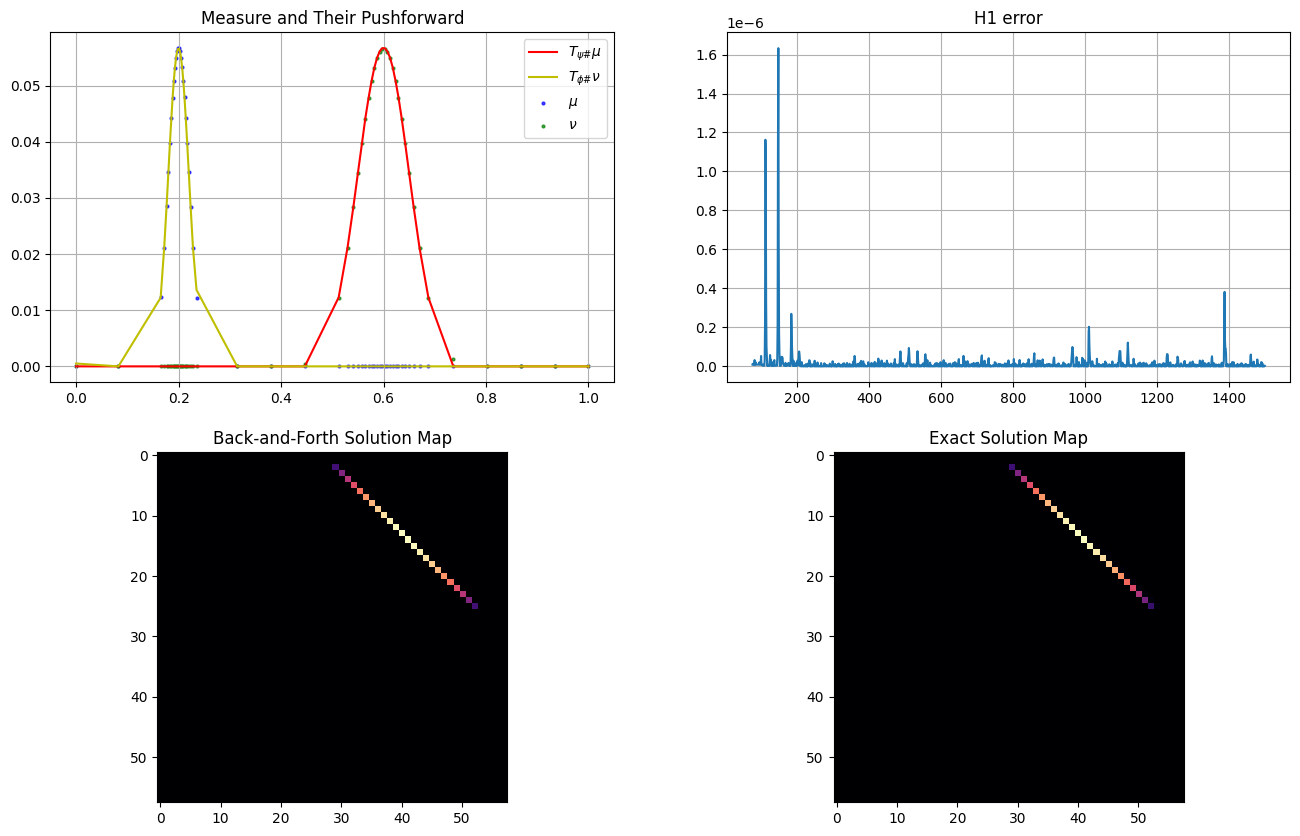

In [25]:
rho1 = pushforward1d(mu, map_T1d(phi, c, x_refined), x_refined)

rho2 = pushforward1d(nu, map_T1d(psi, c, x_refined), x_refined)

T_psi = map_T1d(psi, c, x_refined)
T_phi = map_T1d(phi, c, x_refined)
T = np.zeros((x_refined.shape[0], x_refined.shape[0]))
for i, val in enumerate(T_psi):
    j = np.argmin(np.abs(x_refined - val))
    if rho1[i] != 0 and rho2[j] != 0:
        T[i, j] = rho1[i]

exact_start = time.time()
exact_sol = ot.emd(mu, nu, cost)
print(f"EMD is done in {time.time() - exact_start} sec.")

fig, axs = plt.subplots(2, 2, figsize=(16, 10))

axs[0][0].plot(x_refined, rho1, 'r', label='$T_{\\psi \\#}\\mu$')
axs[0][0].plot(x_refined, rho2, 'y', label='$T_{\\phi \\#}\\nu$')
axs[0][0].scatter(x_refined, mu, s=4, alpha=0.7, c='b', label='$\\mu$')
axs[0][0].scatter(x_refined, nu, s=4, alpha=0.7, c='g', label='$\\nu$')
axs[0][0].legend()
axs[0][0].grid()
axs[0][0].set_title('Measure and Their Pushforward')

err_start = 75
axs[0][1].plot(np.arange(err_start, err1.size), err1[err_start:])
axs[0][1].set_title('H1 error')
axs[0][1].grid()
axs[1][0].imshow(T.T, cmap='magma')
axs[1][0].set_title('Back-and-Forth Solution Map')
axs[1][1].imshow(exact_sol, cmap='magma')
axs[1][1].set_title('Exact Solution Map')
plt.show()

## Uniform to Exponential

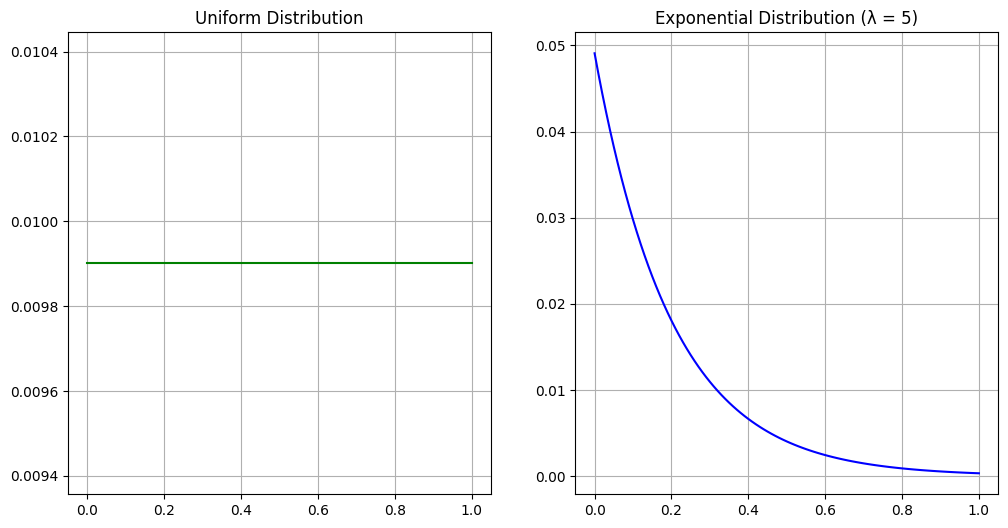

In [26]:
def generate_uniform_distribution(num_points):
    uniform_distribution = np.ones(num_points) / num_points
    uniform_distribution /= uniform_distribution.sum()
    return uniform_distribution

def generate_exponential_distribution(x, num_points, lambd):
    exponential_distribution = lambd * np.exp(-lambd * x)
    exponential_distribution /= exponential_distribution.sum()
    return exponential_distribution

n1 = 100 + 1
n2 = 100 + 1
range_min = 0
range_max = 1
lambd = 5  # rate parameter for exponential distribution

x = np.linspace(range_min, range_max, n1)
y = np.linspace(range_min, range_max, n2)
X, Y = np.meshgrid(x, y, indexing='ij')

mu = generate_uniform_distribution(n1)
nu = generate_exponential_distribution(y, n2, lambd)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(x, mu, 'g-')
axs[0].set_title('Uniform Distribution')
axs[0].grid(True)

axs[1].plot(y, nu, 'b-')
axs[1].set_title('Exponential Distribution (λ = 5)')
axs[1].grid(True)

plt.show()

In [27]:
c = X * Y
cost = np.power(X - Y, 2) / 2

In [28]:
%time
sigma_init = 0.1
phi, psi, err1, mus, nus = back_and_forth1d(
    x, y, mu, nu, c, sigma=sigma_init, iterations=800, accuracy=1e-14)

CPU times: user 3 μs, sys: 1e+03 ns, total: 4 μs
Wall time: 7.15 μs


100%|██████████| 800/800 [00:03<00:00, 224.17it/s, h1=6.13e-9]


EMD is done in 0.0025441646575927734 sec.


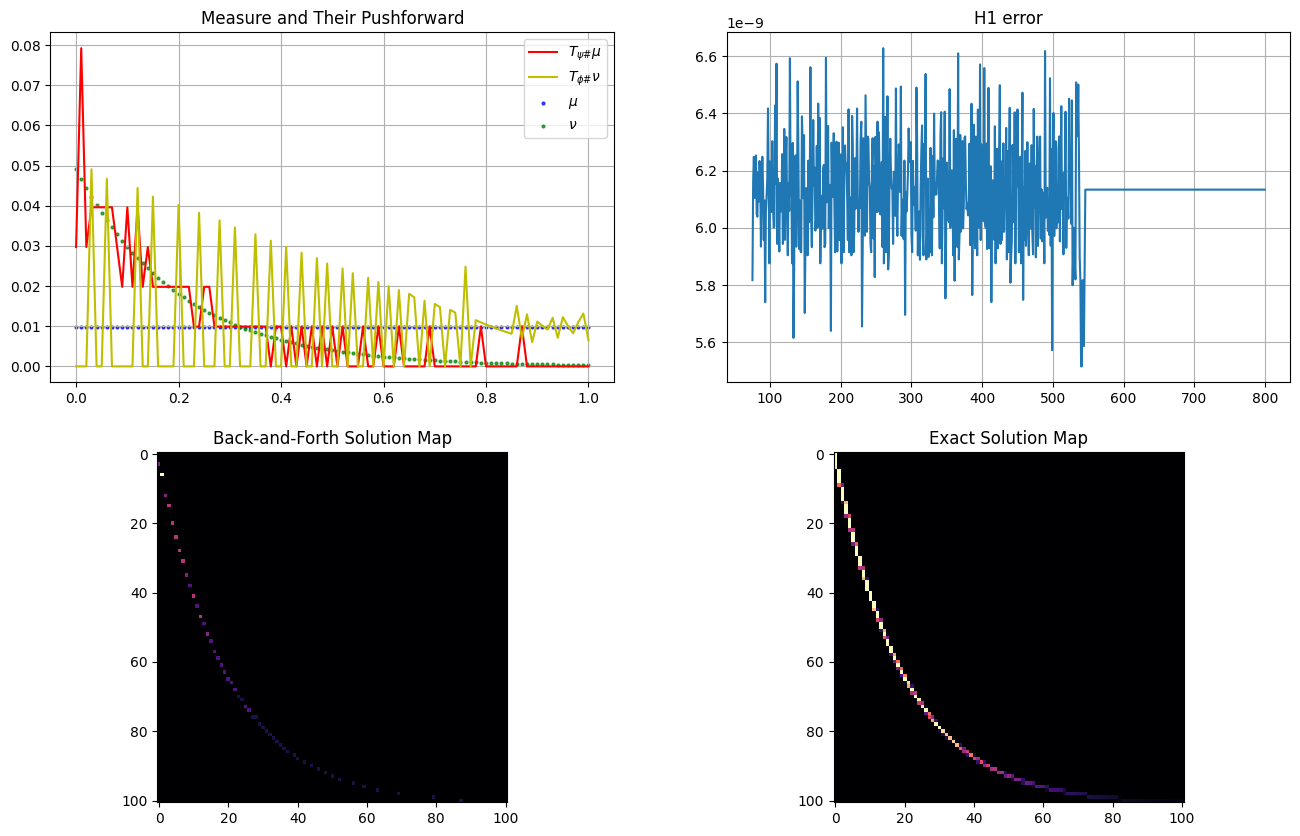

In [29]:
rho1 = pushforward1d(mu, map_T1d(phi, c, x), x)

rho2 = pushforward1d(nu, map_T1d(psi, c, y), y)

T_psi = map_T1d(psi, c, x)
T_phi = map_T1d(phi, c, x)
T = np.zeros((n1, n2))
for i, val in enumerate(T_psi):
    j = np.argmin(np.abs(y - val))
    if rho1[i] != 0 and rho2[j] != 0:
        T[i, j] = rho1[i]

exact_start = time.time()
exact_sol = ot.emd(mu, nu, cost)
print(f"EMD is done in {time.time() - exact_start} sec.")

fig, axs = plt.subplots(2, 2, figsize=(16, 10))

axs[0][0].plot(y, rho1, 'r', label='$T_{\\psi \\#}\\mu$')
axs[0][0].plot(y, rho2, 'y', label='$T_{\\phi \\#}\\nu$')
axs[0][0].scatter(x, mu, s=4, alpha=0.7, c='b', label='$\\mu$')
axs[0][0].scatter(y, nu, s=4, alpha=0.7, c='g', label='$\\nu$')
axs[0][0].legend()
axs[0][0].grid()
axs[0][0].set_title('Measure and Their Pushforward')

err_start = 75
axs[0][1].plot(np.arange(err_start, err1.size), err1[err_start:])
axs[0][1].set_title('H1 error')
axs[0][1].grid()
axs[1][0].imshow(T.T, cmap='magma')
axs[1][0].set_title('Back-and-Forth Solution Map')
axs[1][1].imshow(exact_sol, cmap='magma')
axs[1][1].set_title('Exact Solution Map')
plt.show()